# Project Name: Dimensionality Reduction for Medical Imaging: Applying Variational Autoencoders (VAE) for Image Analysis

*Overview:*
This project is designed to familiarize students with advanced dimensionality reduction techniques, specifically Variational Autoencoders (VAE), applied to medical imaging data. Students will explore how VAEs can effectively reduce complexity, uncover latent representations, and aid in analyzing medical images for better diagnostics and visualization.

*You have:*
* A medical imaging dataset (e.g., MRI, CT scans, or X-rays) suitable for deep learning applications.
* Fundamental knowledge of Python, TensorFlow or PyTorch, image processing basics, and deep learning concepts.

*We will:*
1. Preprocess and normalize medical imaging data, ensuring consistency and suitability for VAE training.
2. Implement and train a Variational Autoencoder architecture to learn compact latent representations from high-dimensional medical images.
3. Visualize and interpret the reconstructed images and latent space, evaluating the effectiveness of VAE in capturing meaningful diagnostic features.

*Goal:*
Enable students to acquire practical expertise in using VAEs for medical image analysis, facilitating enhanced understanding of complex imaging data and improving diagnostic processes in medical applications.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, losses
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
import base64
from IPython.display import display, HTML
import os
import warnings
warnings.filterwarnings("ignore")

## Notebook utility

In [21]:
prefix_path = "../img/"
image_paths = ["vae1.png","vae2.png","vae3.webp","vae4.jpg","vae5.jpg"]
image_width = [700, 700, 700, 700, 700, 700]
images_html = []

mime_map = {
    ".png": "image/png",
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".gif": "image/gif",
    ".webp": "image/webp"
}

for i, path in enumerate(image_paths):
    ext = os.path.splitext(prefix_path+path)[1].lower()
    mime = mime_map.get(ext, "image/png")

    with open(prefix_path+path, "rb") as f:
        data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")

    img_tag = f'<img src="data:{mime};base64,{encoded}" style="display: block; margin-left: auto; margin-right: auto; width: {image_width[i]}px;" /><br>'
    images_html.append(img_tag)

## Theoretical Background


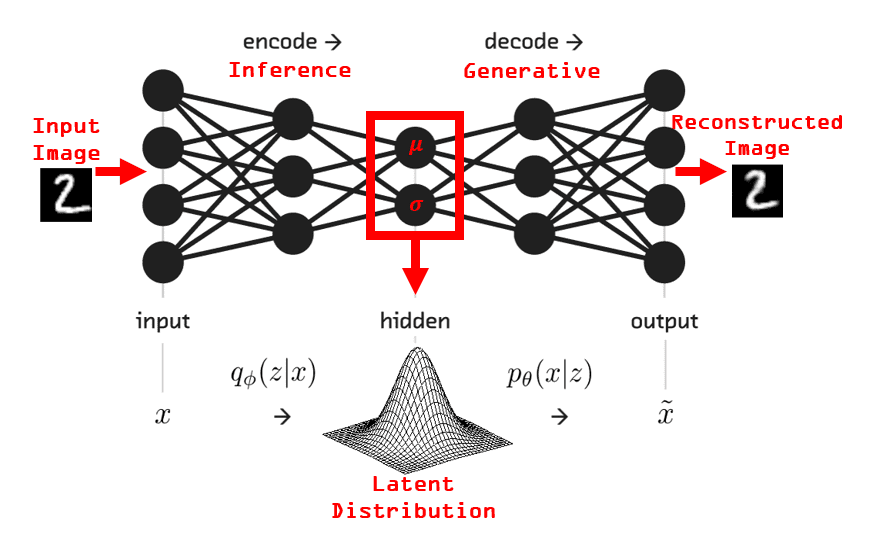

In [22]:
display(HTML(images_html[0]))


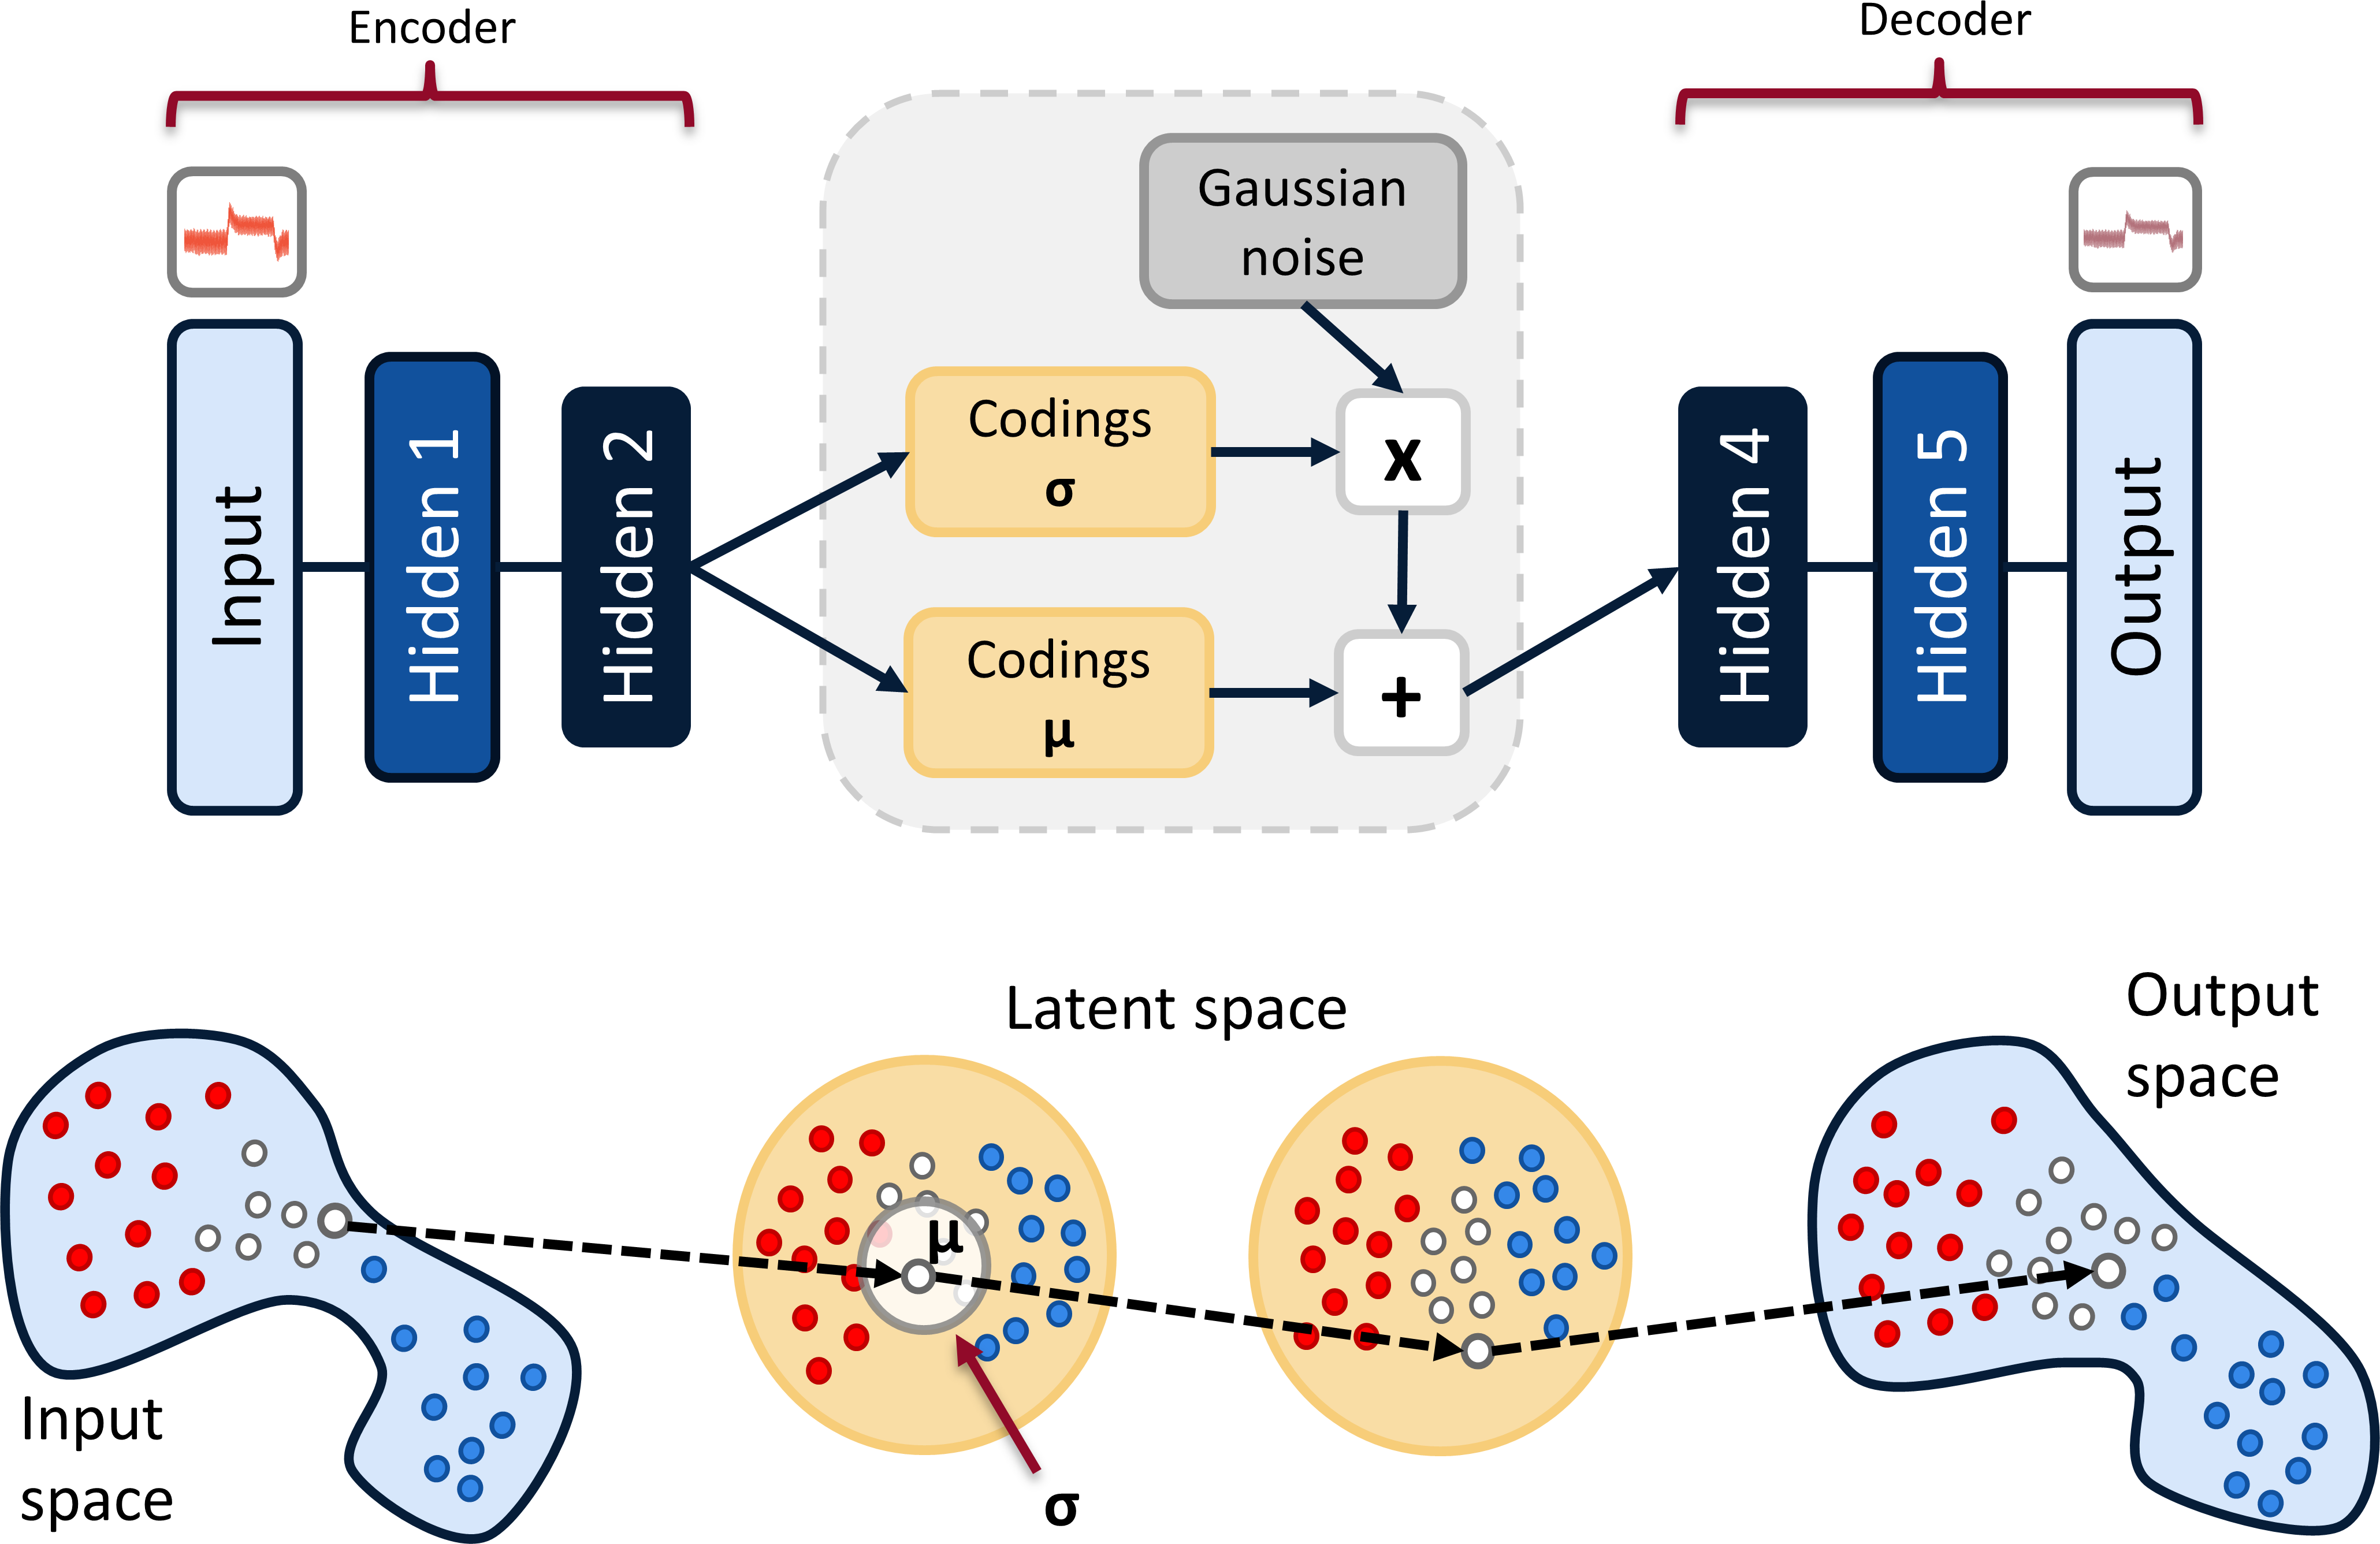

In [23]:
display(HTML(images_html[1]))


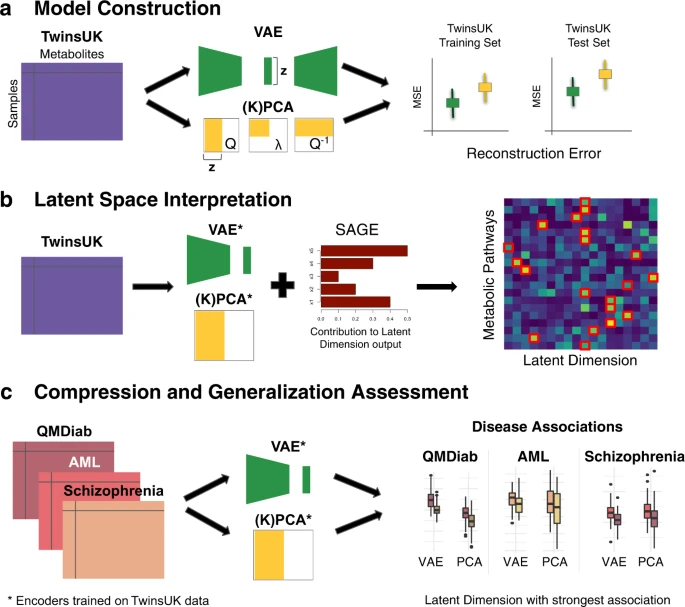

In [24]:
display(HTML(images_html[2]))


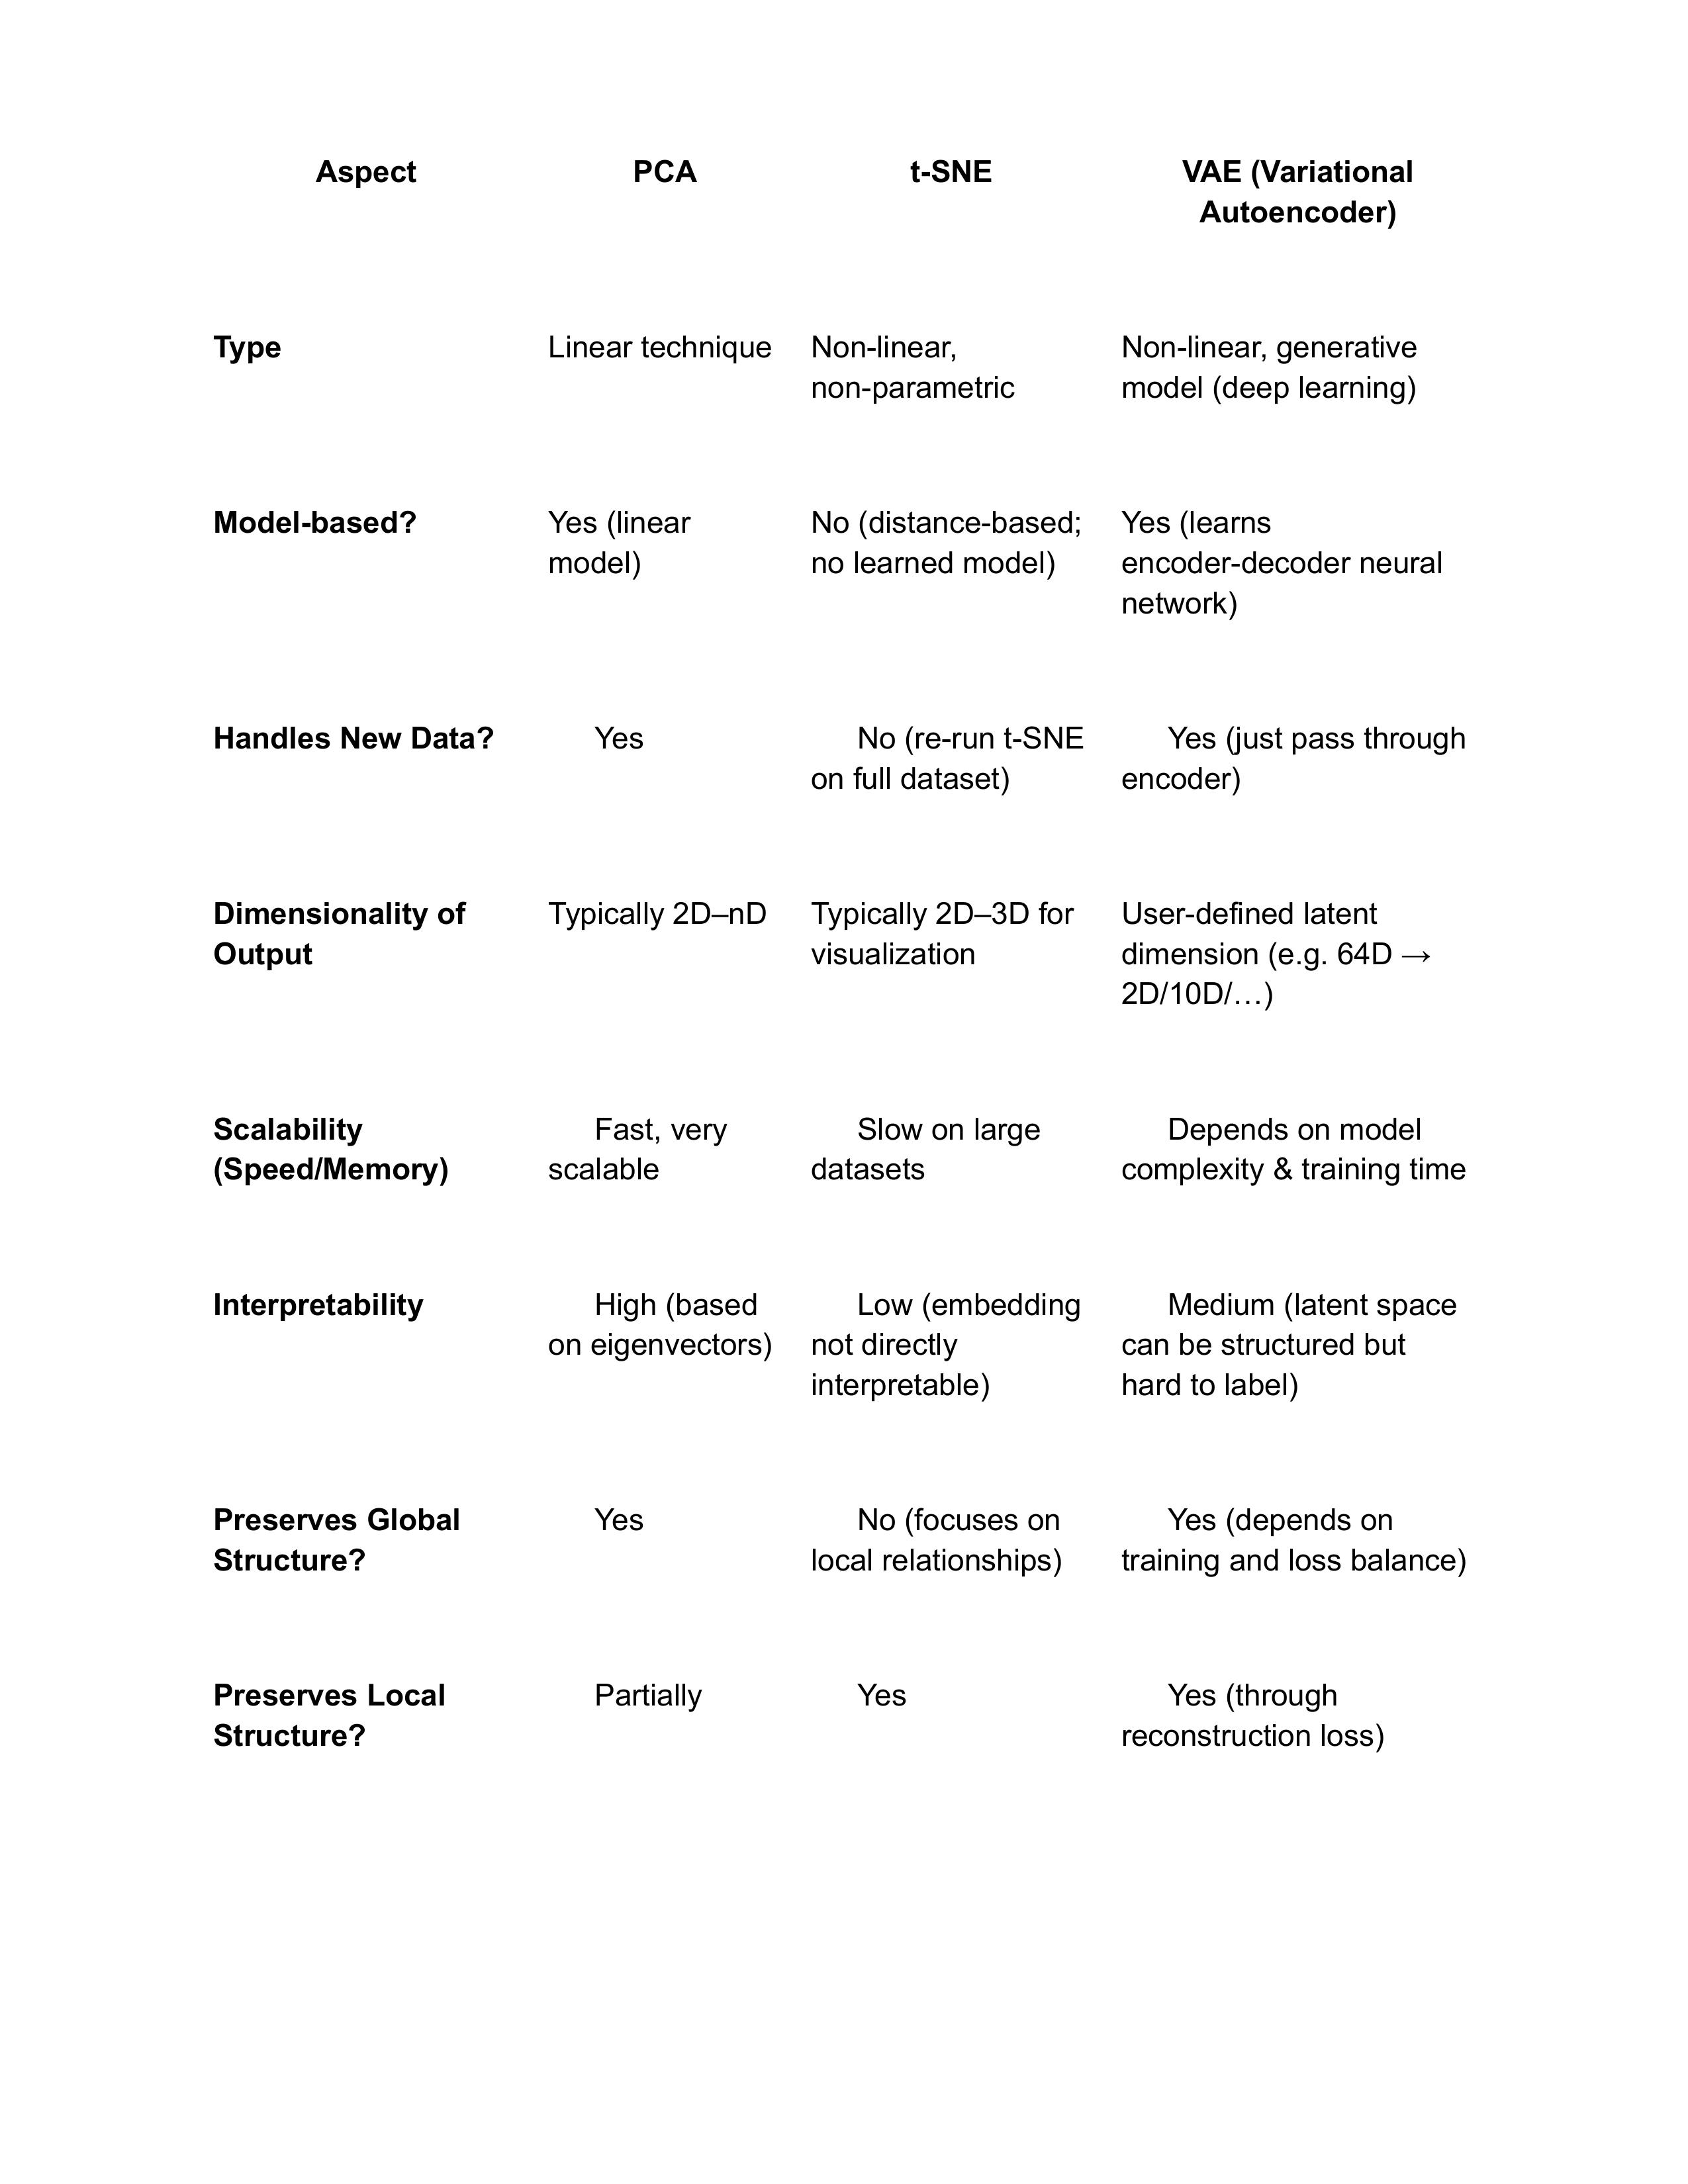

In [25]:
display(HTML(images_html[3]))


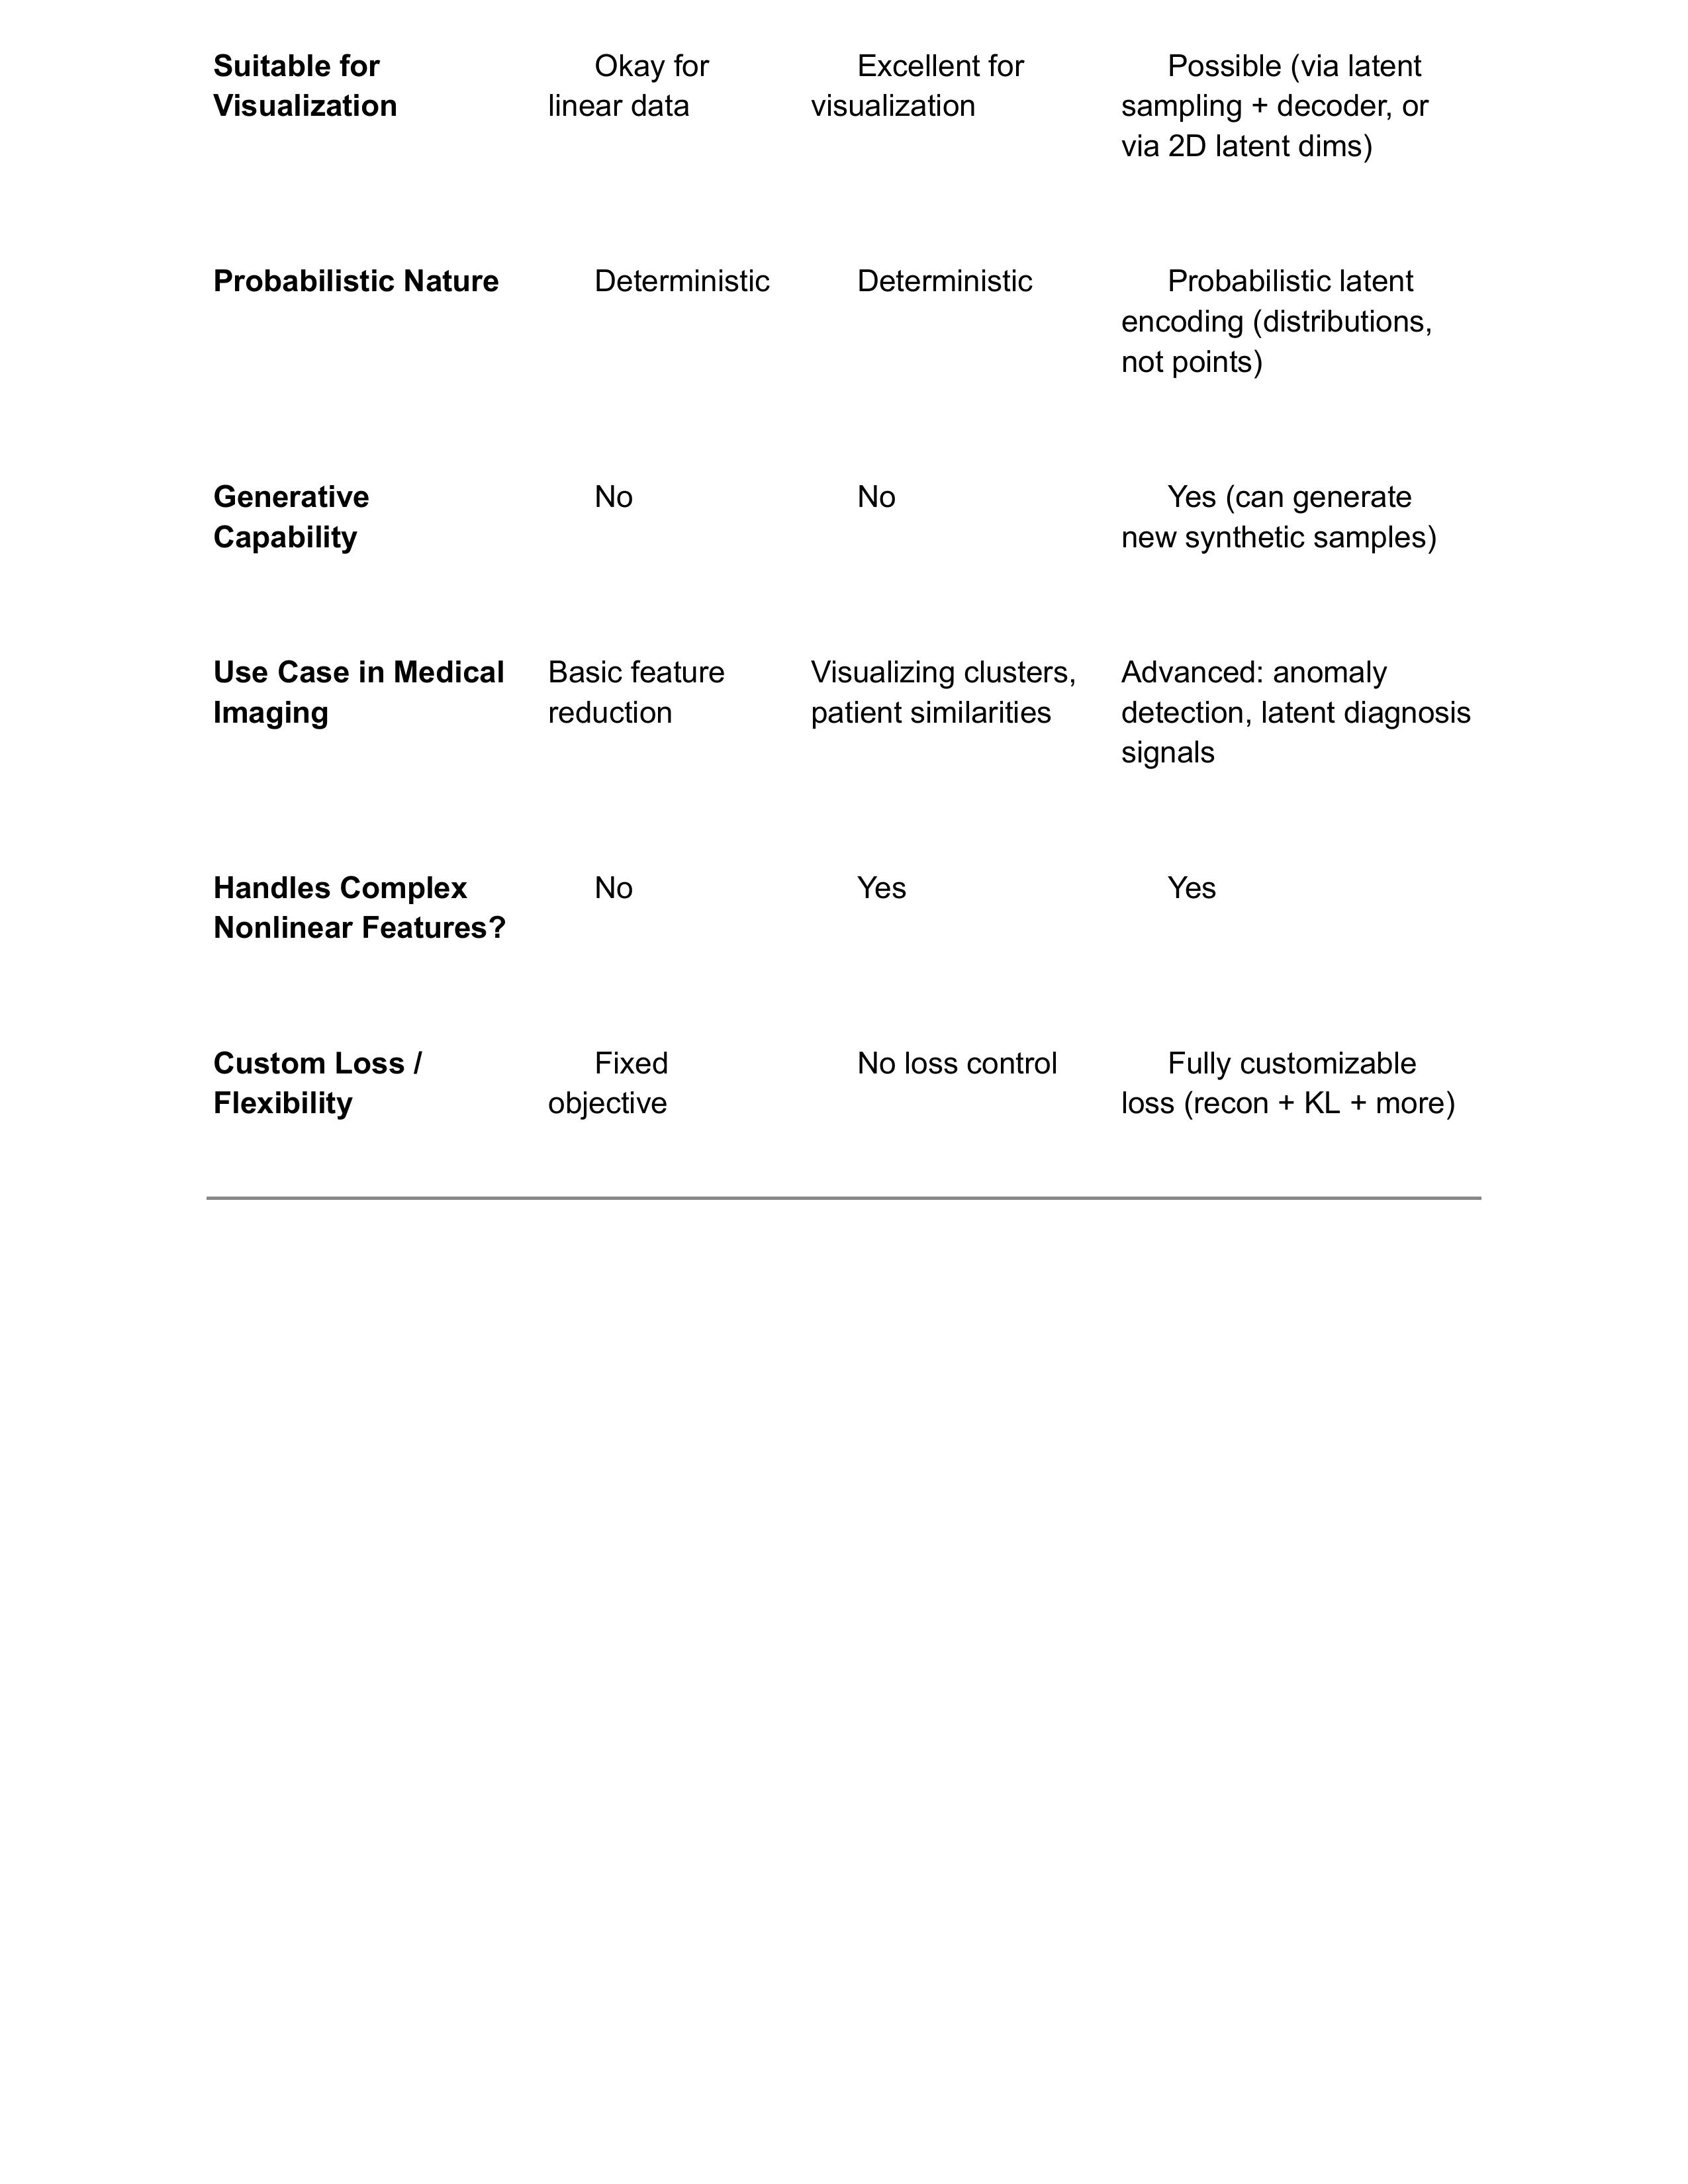

In [26]:
display(HTML(images_html[4]))

## Loading and peeking Data

In [3]:
data_dir = "../input/medical-mnist/HeadCT/"
img_size = (64, 64)
batch_size = 32

Found 10000 files.
Total images found on disk: 10000
Batch tensor shape: (32, 64, 64, 1)


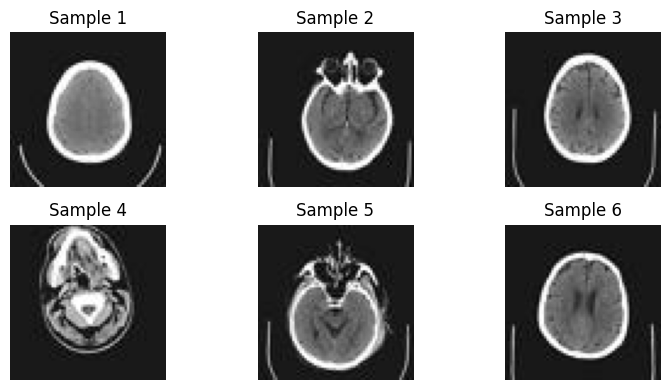

In [5]:
# Use Keras utility to load images as a tf.data.Dataset
dataset = image_dataset_from_directory(
    data_dir,
    labels=None,
    color_mode="grayscale",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
)

# Count total number of image files in all subdirectories
valid_exts = (".jpeg")
total_images = 0
for root, _, files in os.walk(data_dir):
    total_images += sum(f.lower().endswith(valid_exts) for f in files)
print(f"Total images found on disk: {total_images}")

# Peek at one batch to inspect tensor shapes and visualize samples
for batch in dataset.take(1):
    print("Batch tensor shape:", batch.shape)  # (batch_size, height, width, channels)
    # Display first 6 images from this batch
    plt.figure(figsize=(8, 4))
    for i in range(min(6, batch.shape[0])):
        ax = plt.subplot(2, 3, i + 1)
        # Squeeze channel dim and plot as grayscale
        plt.imshow(tf.squeeze(batch[i]), cmap="gray")
        plt.title(f"Sample {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

## Normalizing data

In [6]:
# Normalize pixel values to [0,1]
def normalize(images):
    images = tf.cast(images, tf.float32) / 255.0
    return images

dataset = dataset.map(normalize)

# Split into train and validation sets
val_fraction = 0.2
dataset = dataset.unbatch().cache()
all_images = np.stack(list(dataset.as_numpy_iterator()))
train_imgs, val_imgs = train_test_split(all_images, test_size=val_fraction, random_state=42)
train_ds = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(1000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices(val_imgs).batch(batch_size)

## VAE architecture

In [7]:
# Implement the Variational Autoencoder (VAE) architecture

latent_dim = 64  

# Encoder
encoder_inputs = layers.Input(shape=(*img_size, 1), name="encoder_input")
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)  
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)              
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)

# Two outputs: mean and log-variance for latent distribution
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling function using the reparameterization trick
def sample_z(args):
    mean, log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(mean)[0], latent_dim))
    return mean + tf.exp(0.5 * log_var) * epsilon

# Latent vector
z = layers.Lambda(sample_z, name="z")([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      2,097,280 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,132,608 (8.14 MB)

 Trainable params: 2,132,608 (8.14 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Decoder
latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)       
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16384)               │       1,064,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,120,641 (4.27 MB)

 Trainable params: 1,120,641 (4.27 MB)

 Non-trainable params: 0 (0.00 B)

#### - Encoder-Decoder Architecture:
####   The encoder maps high-dimensional images into a low-dimensional latent space (z_mean, z_log_var).
####   The decoder reconstructs images from points in this latent space.

#### - Latent Space Representation:
####   The latent vectors capture essential features of the images in a compressed form.
####   In medical imaging, inspecting the latent space can reveal clusters or anomalies.

## VAE Training

In [9]:
# VAE as a Model subclass to add the custom loss
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # 1) encode to get z_mean, z_log_var, and sampled z
        z_mean, z_log_var, z = self.encoder(inputs)
        # 2) decode z back to reconstruction
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):  # disregard labels if present
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Reconstruction loss: binary crossentropy per pixel
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)         # sum across H and W only
                )
            )
            
            # KL divergence: measure difference from unit normal
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = recon_loss + kl_loss

        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss, "reconstruction_loss": recon_loss, "kl_loss": kl_loss}

    def test_step(self, data):
        # mirror train_step but without gradients
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                losses.binary_crossentropy(data, reconstruction),
                axis=(1, 2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = recon_loss + kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss,
        }

# Instantiate and compile the VAE
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss=lambda y_true, y_pred: 0,
    run_eagerly=True
)

#### - Reparameterization Trick:
####   Allows backpropagation through the stochastic sampling step by expressing sampling
####   as a differentiable operation: z = mean + exp(0.5 * log_var) * epsilon.

#### - Loss Functions:
####   Reconstruction loss ensures the output resembles the input.
####   KL divergence regularizes the latent distribution to approximate a standard normal,
####   encouraging continuity and completeness in the latent space.


In [10]:
epochs = 30
history = vae.fit(train_ds,
                  epochs=epochs,
                  validation_data=val_ds)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 331ms/step - kl_loss: 26.1053 - loss: 2136.0393 - reconstruction_loss: 2109.9341 - val_kl_loss: 18.5572 - val_loss: 1979.8666 - val_reconstruction_loss: 1961.3093
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 331ms/step - kl_loss: 20.0739 - loss: 1910.6471 - reconstruction_loss: 1890.5732 - val_kl_loss: 19.4779 - val_loss: 1948.6010 - val_reconstruction_loss: 1929.1230
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 318ms/step - kl_loss: 22.4123 - loss: 1874.9430 - reconstruction_loss: 1852.5306 - val_kl_loss: 21.9347 - val_loss: 1920.3256 - val_reconstruction_loss: 1898.3909
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 312ms/step - kl_loss: 23.1731 - loss: 1858.6113 - reconstruction_loss: 1835.4382 - val_kl_loss: 23.6816 - val_loss: 1915.1523 - val_reconstruction_loss: 1891.4707
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 310ms/step - kl_loss: 23.9971 - loss: 1836.7241 - reconstruction_loss: 1812.7271 - val_kl_loss: 25.8711 - val_loss: 1877.1564 -

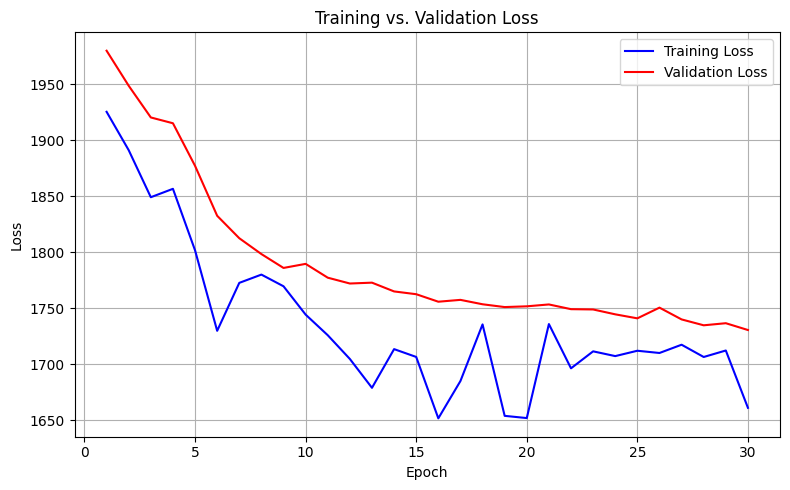

In [11]:
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

# Create an array of epoch indices
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss,   'r-', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## VAE evaluation

In [12]:
# Visualize and interpret reconstructions
def plot_reconstructions(model, data, n=5):
    idx = np.random.choice(len(data), n)
    samples = data[idx]
    recon = model.decoder(model.encoder(samples)[2])
    plt.figure(figsize=(2 * n, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(samples[i].squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")
        # Reconstruction
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(recon[i].numpy().squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

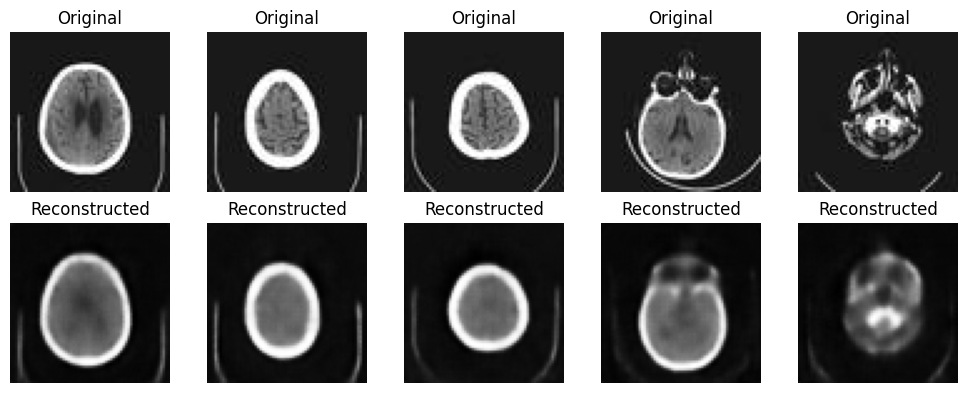

In [13]:
# Plot a few examples
plot_reconstructions(vae, val_imgs)